Lucas-Kanade's algorithm (LK):
Tracks only the chosen points in the image by calulating the sparse optical flow

Gunner Farneback's algorithm (GF): 
calculates flow of all points in an image by calculating dense optiacl flow

# Part 59: Optical Flow Coding with OpenCV 

## Using Sparse Optical Flow

In [1]:
import numpy as np
import cv2

In [2]:
corner_track_params = dict(maxCorners=10, qualityLevel=0.3, minDistance=7, blockSize=7)
# maxCorner: max number of points to track

In [4]:
lk_params = dict(winSize=(200,200), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10,0.03)) # LK params
# larger window: tracks faster movements, not sensitive to small movement
# smaller window: can't track faster movements, sensitive to small movement

# Level: LK uses image pyramid in its methods. Each level corresponds to a resolution. Level2=res. 1/(2^level)=1/4
# Image pyramid: signal or an image is subject to repeated smoothing and subsampling. 

# criteria EPS: epsilon choice (here 0.03) which exchanges speed vs. accuracy or our tracking.
# smaller epsilon ends tracking sooner.
# Criteria count: number of iterations (here 10)

In [ ]:
cap = cv2.VideoCapture(0)

ret, pre_frame = cap.read()

pre_gray = cv2.cvtColor(pre_frame, cv2.COLOR_BGR2GRAY)

# Points to track
prevPts = cv2.goodFeaturesToTrack(pre_gray, mask=None, **corner_track_params)

mask = np.zeros_like(pre_frame) # for visualizing

while True:
    
    ret, frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    nextPts, status, err = cv2.calcOpticalFlowPyrLK(pre_gray, frame_gray, prevPts, None, **lk_params)
    # status returns a vector that contains ones where it has found optical flow for the corresponding features
    # we're tracking max 10 points here, as defined in dictionary lk_params
    
    # Connecting the previous points to next points
    good_new = nextPts[status==1]
    good_pre = prevPts[status==1]
    
    for i, (new,prev) in enumerate(zip(good_new, good_pre)):
        
        x_new, y_new = new.ravel() # flatens a matrix, same as reshape(-1, order=order)
        x_prev, y_prev = prev.ravel()
        x_new = int(x_new)
        y_new = int(y_new)
        x_prev = int(x_prev)
        y_prev = int(y_prev)

        
        mask = cv2.line(mask, (x_new,y_new), (x_prev,y_prev), (0,255,0), 3)
        
        frame = cv2.circle(frame, (x_new,y_new), 8, (0,0,255), -1)
    
    img = cv2.add(frame, mask)
    cv2.imshow('Tracking', img)
    
    k = cv2.waitKey(30) & 0xFF
    if k==27:
        break
        
    prev_gray = frame_gray.copy()
    prevPts = good_new.reshape(-1,1,2) # change to the format accepted by cv2.goodFeaturesToTrack

    
cv2.destroyAllWindows()
cap.release()

## Using Dense Optical Flow
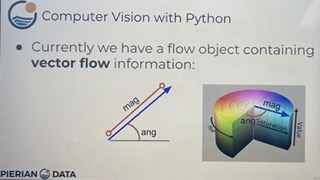

In [ ]:
cap = cv2.VideoCapture(0)
ret, frame1 = cap.read()

prvsImg = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

hsv_mask = np.zeros_like(frame1)
hsv_mask[:,:,1] = 255

while True:
    ret, frame2 = cap.read()
    nextImg = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    
    flow = cv2.calcOpticalFlowFarneback(prvsImg, nextImg, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # flow gives x and y of the flow arrow in the direction of movement
    # we change it to polar coordinate to use it for HSV coloring
    
    mag, ang = cv2.cartToPolar(flow[:,:,0], flow[:,:,1], angleInDegrees=True) #flow: for each pixel, x and y
   
    hsv_mask[:,:,0] = ang/2
    hsv_mask[:,:,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    bgr = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR)
    cv2.imshow('Frame', bgr)
    
    k = cv2.waitKey(10) & 0xFF
    if k == 27:
        break
        
    prvsImg = nextImg
    
cap.release()
cv2.destroyAllWindows()

# 61. MeanShift and CamShift Tracking Theory

In [22]:
import cv2
import numpy as np

In [ ]:
cap = cv2.VideoCapture(0)

ret, frame = cap.read()

# We first detect face and then track it by meanshift algorithm
face_cascade = cv2.CascadeClassifier('DATA/haarcascades/haarcascade_frontalface_default.xml')
face_rects = face_cascade.detectMultiScale(frame)

(face_x, face_y, w, h) = tuple(face_rects[0])
track_window = (face_x, face_y, w, h) # ow we wanna track this window

roi = frame[face_y:face_y+h, face_x: face_x+w]
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

roi_hist = cv2.calcHist([hsv_roi], [0], None, [180], [0,180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

term_criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1) # meaning we're going for at least one epsilon or 10 iteration

while True:
    
    ret, frame = cap.read()
    
    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0,180], 1)
        
        ret, track_window = cv2.meanShift(dst, track_window, term_criteria)
        
        x, y, w, h = track_window
        
        img2 = cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255), 5)
        cv2.imshow('Image', img2)
        
        k = cv2.waitKey(1) & 0xFF
        if k == 27:
            break
            
    else:
        break
        
cv2.destroyAllWindows()
cap.release()

In [ ]:
# CAMshift
cap = cv2.VideoCapture(0)

ret, frame = cap.read()

# We first detect face and then track it by meanshift algorithm
face_cascade = cv2.CascadeClassifier('DATA/haarcascades/haarcascade_frontalface_default.xml')
face_rects = face_cascade.detectMultiScale(frame)

(face_x, face_y, w, h) = tuple(face_rects[0])
track_window = (face_x, face_y, w, h) # ow we wanna track this window

roi = frame[face_y:face_y+h, face_x: face_x+w]
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

roi_hist = cv2.calcHist([hsv_roi], [0], None, [180], [0,180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

term_criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1) # meaning we're going for at least one epsilon or 10 iteration

while True:
    
    ret, frame = cap.read()
    
    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0,180], 1)
        
        ############ This part is changed in CAMshift
        ret, track_window = cv2.CamShift(dst, track_window, term_criteria)
        
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv2.polylines(frame, [pts], True, (0,0,255), 5)
        ############
        
        cv2.imshow('Image', img2)
        
        k = cv2.waitKey(1) & 0xFF
        if k == 27:
            break
            
    else:
        break
        
cv2.destroyAllWindows()
cap.release()